In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 27 11:11:44 2023

@author: bas
copied from: https://github.com/xpsi-group/xpsi/blob/main/examples/examples_fast/Synthetic_data.ipynb
"""



import os
import numpy as np
import math


from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import xpsi
from xpsi import Parameter, HotRegions, Elsewhere
from scipy.interpolate import Akima1DInterpolator
from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi
from xpsi.tools.synthesise import synthesise_exposure_no_scaling as _synthesise # no scaling!

import sys
sys.path.append('../../')
sys.path.append('../')
from custom_tools import SynthesiseData, plot_one_pulse

from CustomBackground import CustomBackground_DiskBB
from CustomPrior import CustomPrior
from CustomInstrument import CustomInstrument
from CustomPhotosphere import CustomPhotosphere
from CustomInterstellar import CustomInterstellar
from CustomSignal import CustomSignal
from CustomHotregion import CustomHotRegion_Accreting

from helper_functions import get_T_in_log10_Kelvin, plot_2D_pulse

this_directory = '/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic'
print('this_directory: ', this_directory)

################################## SETTINGS ###################################

second = False
te_index = 0

try: #try to get parameters from shell input
    os.environ.get('atmosphere_type')    
    atmosphere_type = os.environ['atmosphere_type']
    os.environ.get('n_params')
    n_params = os.environ['n_params']
    os.environ.get('machine')
    machine = os.environ['machine']
except:
    atmosphere_type = "A"
    n_params = "5"
    machine = "local"



exposure_time=1.32366e5 ## is the same as Mason 2019

print("atmosphere_type:", atmosphere_type)
print("n_params:", n_params)

################################## INSTRUMENT #################################
channel_low = 20
channel_hi = 300 #600
max_input = 1400 #2000

ARF_file=this_directory + '/../model_data/instrument_data/J1808_NICER_2019/merged_saxj1808_2019_arf_aeff.txt'
RMF_file=this_directory + '/../model_data/instrument_data/J1808_NICER_2019/merged_saxj1808_2019_rmf_matrix.txt'
channel_edges_file=this_directory + '/../model_data/instrument_data/J1808_NICER_2019/merged_saxj1808_2019_rmf_energymap.txt'

try:   
    NICER = CustomInstrument.from_response_files(ARF = ARF_file,
            RMF = RMF_file,
            channel_edges = channel_edges_file,
            channel_low=channel_low,
            channel_hi=channel_hi,
            max_input=max_input)

except:
    print('error! No instrument file!')

############################### SPACETIME #####################################

bounds = dict(distance = (3.4, 3.6),                       # (Earth) distance
                mass = (1.0, 3.0),                          # mass
                radius = (3.0 * gravradius(1.0), 16.0),     # equatorial radius
                cos_inclination = (0.0, 1.0))               # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=401.0))# Fixing the spin

############################### SINGLE HOTREGION ##############################

num_leaves = 128
sqrt_num_cells = 128
num_rays = 512

kwargs = {'symmetry': 'azimuthal_invariance', #call general integrator instead of for azimuthal invariance
          'interpolator': 'split',
          'omit': False,
          'cede': False,
          'concentric': False,
          'sqrt_num_cells': sqrt_num_cells,
          'min_sqrt_num_cells': 10,
          'max_sqrt_num_cells': 128,
          'num_leaves': num_leaves,
          'num_rays': num_rays,
          'prefix': 'p'}
values = {}
bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (-0.25, 0.75))
if atmosphere_type=='A':
    bounds['super_tbb'] = (0.001, 0.003)
    bounds['super_tau'] = (0.5, 3.5)
    if n_params=='5':
        bounds['super_te'] = (40., 200.)
        primary = CustomHotRegion_Accreting(bounds, values, **kwargs)

hot = HotRegions((primary,))


################################### ELSEWHERE ################################

elsewhere = Elsewhere(bounds=dict(elsewhere_temperature = (5.0,7.0)))

################################ ATMOSPHERE ################################### 
      

photosphere = CustomPhotosphere(hot = hot, elsewhere = elsewhere,
                                values=dict(mode_frequency = spacetime['frequency']))
# LOCAL
if machine=='local':
    photosphere.hot_atmosphere = '/home/bas/Documents/Projects/x-psi/model_datas/bobrikova/Bobrikova_compton_slab.npz'
# SNELLIUS
elif machine=='snellius':
    photosphere.hot_atmosphere = '/home/dorsman/xpsi-bas-fork/AMXPs/model_data/Bobrikova_compton_slab.npz'

    
################################### STAR ######################################

star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

#################################### PRIOR ####################################

prior = CustomPrior()

################################## INTERSTELLAR ###################################
if machine=='local':
    interstellar = CustomInterstellar.from_SWG("/home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/model_data/n_H/TBnew/tbnew0.14.txt", bounds=(None, None), value=None)
elif machine=='snellius':
    interstellar = CustomInterstellar.from_SWG("/home/dorsman/xpsi-bas-fork/AMXPs/model_data/interstellar/tbnew/tbnew0.14.txt", bounds=(None, None), value=None)


############################### BACKGROUND ####################################

background = CustomBackground_DiskBB(bounds=(None, None), values={}, interstellar = interstellar)

###################### SYNTHESISE DATA #################################

phases_space = np.linspace(0.0, 1.0, 33)
_data = SynthesiseData(np.arange(channel_low,channel_hi), phases_space, 0, channel_hi-channel_low-1)

################################## SIGNAL ###################################

signal = CustomSignal(data = _data,
                        instrument = NICER,  # Instrument
                        background = background,
                        interstellar = interstellar,
                        cache = True,
                        prefix='Instrument') # I can't change this?

################################# LIKELIHOOD ###############################

likelihood = xpsi.Likelihood(star = star, signals = signal,
                             num_energies=128, #384
                             threads=8, #1
                             externally_updated=False,
                             prior = prior)                             

for h in hot.objects:
    h.set_phases(num_leaves)


# SAX J1808-like 
mass = 1.4
radius = 12.
distance = 3.5
inclination = 60
cos_i = math.cos(inclination*math.pi/180)

# Hotspot
phase_shift = 0
super_colatitude = 45*math.pi/180 # 20*math.pi/180 # 
super_radius = 15.5*math.pi/180



# Compton slab model parameters
tbb=0.0012 # 0.0017 #0.001 -0.003 Tbb(data) = Tbb(keV)/511keV, 1 keV = 0.002 data
te=100. # 50. # 40-200 corresponds to 20-100 keV (Te(data) = Te(keV)*1000/511keV), 50 keV = 100 data
tau=1. #0.5 - 3.5 tau = ln(Fin/Fout)

# elsewhere
elsewhere_T_keV = 0.4 # 0.5 #  keV 

# source background
column_density = 1.17 #10^21 cm^-2
diskbb_T_keV = 0.25 # 0.3  #  keV #0.3 keV for Kajava+ 2011
r_in = 30 # 20 #  1 #  km #  for very small diskBB background

p = [mass, #1.4, #grav mass
      radius,#12.5, #coordinate equatorial radius
      distance, # earth distance kpc
      cos_i, #cosine of earth inclination
      phase_shift, #phase of hotregion
      super_colatitude, #colatitude of centre of superseding region
      super_radius,  #angular radius superceding region
      tbb,
      te,
      tau
      ]

elsewhere_T_log10_K = get_T_in_log10_Kelvin(elsewhere_T_keV)
p.append(elsewhere_T_log10_K) # 10^x Kelvin

diskbb_T_log10_K = get_T_in_log10_Kelvin(diskbb_T_keV)
p.append(diskbb_T_log10_K)

K_disk = cos_i*(r_in/(distance/10))**2  # (km / 10 kpc)^2
# K_disk = 0
p.append(K_disk)

if isinstance(interstellar, xpsi.Interstellar):

    p.append(column_density)

Instrument_kwargs = dict(exposure_time=exposure_time,
                         name='J1808_synthetic',
                         directory='./data/')


likelihood.synthesise(p, force=True, Instrument=Instrument_kwargs) 

print("Done !")



/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1
this_directory:  /home/bas/Documents/Projects/x-psi/xpsi-bas-fork/AMXPs/J1808_synthetic
atmosphere_type: A
n_params: 5
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.
Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:


In [2]:
signal.signals[0]

array([[0.00332602, 0.00332342, 0.00332054, ..., 0.00333026, 0.00332831,
        0.00332602],
       [0.00486029, 0.00485653, 0.00485236, ..., 0.00486644, 0.0048636 ,
        0.00486029],
       [0.00683956, 0.00683443, 0.00682874, ..., 0.00684795, 0.00684408,
        0.00683956],
       ...,
       [0.02895576, 0.02874431, 0.02852479, ..., 0.0293494 , 0.02915788,
        0.02895576],
       [0.02845756, 0.02824784, 0.02803017, ..., 0.02884818, 0.02865809,
        0.02845756],
       [0.02796369, 0.02775573, 0.02753994, ..., 0.02835123, 0.02816261,
        0.02796369]])

In [3]:
signal.expected_counts

array([[ 23.30776167,  23.25070395,  23.18170858, ...,  23.35466884,
         23.36449758,  23.3474536 ],
       [ 36.00829256,  35.92590294,  35.82639879, ...,  36.0768276 ,
         36.0906234 ,  36.06574126],
       [ 54.30490345,  54.19238225,  54.05647447, ...,  54.39831686,
         54.41725343,  54.38333461],
       ...,
       [119.16416359, 115.33605996, 111.31633037, ..., 126.60572421,
        125.12856444, 122.53514507],
       [117.07561963, 113.28201554, 109.30130996, ..., 124.4718123 ,
        122.99697697, 120.4196652 ],
       [115.00657259, 111.2479597 , 107.3067312 , ..., 122.35594214,
        120.88386854, 118.32316788]])

In [4]:
(signal.background.registered_background+signal.star_counts)*exposure_time

array([[ 23.30776167,  23.25070395,  23.18170858, ...,  23.35466884,
         23.36449758,  23.3474536 ],
       [ 36.00829256,  35.92590294,  35.82639879, ...,  36.0768276 ,
         36.0906234 ,  36.06574126],
       [ 54.30490345,  54.19238225,  54.05647447, ...,  54.39831686,
         54.41725343,  54.38333461],
       ...,
       [119.16416359, 115.33605996, 111.31633037, ..., 126.60572421,
        125.12856444, 122.53514507],
       [117.07561963, 113.28201554, 109.30130996, ..., 124.4718123 ,
        122.99697697, 120.4196652 ],
       [115.00657259, 111.2479597 , 107.3067312 , ..., 122.35594214,
        120.88386854, 118.32316788]])

In [5]:
signal.star_counts

array([[0.00010376, 0.00010333, 0.00010281, ..., 0.00010412, 0.00010419,
        0.00010406],
       [0.00015163, 0.00015101, 0.00015026, ..., 0.00015215, 0.00015225,
        0.00015206],
       [0.00021339, 0.00021254, 0.00021151, ..., 0.0002141 , 0.00021424,
        0.00021398],
       ...,
       [0.00089137, 0.00086245, 0.00083208, ..., 0.00094759, 0.00093643,
        0.00091683],
       [0.00087591, 0.00084725, 0.00081718, ..., 0.00093179, 0.00092065,
        0.00090117],
       [0.00086059, 0.0008322 , 0.00080242, ..., 0.00091612, 0.00090499,
        0.00088565]])

data plot saved in plots/J1808_synthetic_realisation_exp_time=132366.0.png
signal plot saved in plots/J1808.png
26094259.0


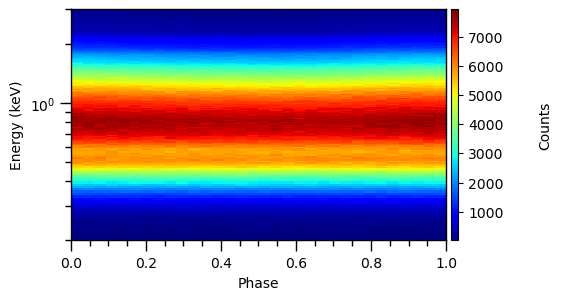

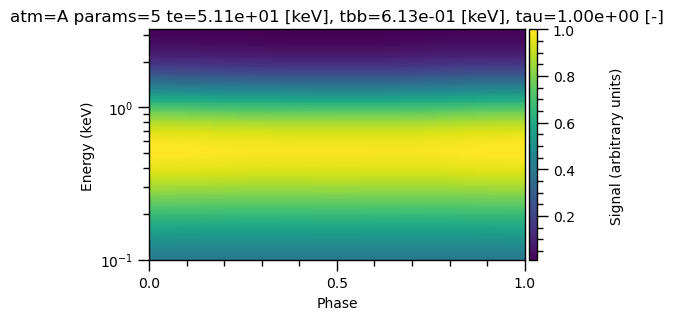

In [6]:
########## DATA PLOT ###############

my_data=np.loadtxt('./data/J1808_synthetic_realisation.dat'.format(atmosphere_type, n_params))


figstring = f'J1808_synthetic_realisation_exp_time={exposure_time}.png'


fig1,ax1 = plot_one_pulse(my_data, phases_space, NICER.channel_edges, cm=cm.jet)

try:
    os.makedirs('./plots')
except OSError:
    if not os.path.isdir('./plots'):
        raise
fig1.savefig('./plots/'+figstring)
print('data plot saved in plots/{}'.format(figstring))

################ SIGNAL PLOT ###################################

num_rotations=1

fig2,ax2 = plot_2D_pulse((photosphere.signal[0][0],),
              x=signal.phases[0],
              shift=signal.shifts,
              y=signal.energies,
              ylabel=r'Energy (keV)',
              num_rotations=num_rotations,
              res=int(30*num_rotations))


ax2.set_title('atm={} params={} te={:.2e} [keV], tbb={:.2e} [keV], tau={:.2e} [-]'.format(atmosphere_type, n_params, te*0.511, tbb*511, tau), loc='center') #unit conversion te and tbb is different due to a cluster leftover according to Anna B.


fig2.savefig('./plots/J1808.png')
print('signal plot saved in plots/J1808.png')

print(np.sum(my_data))


In [7]:
my_data

array([[ 26.,  23.,  21., ...,  22.,  21.,  21.],
       [ 35.,  38.,  34., ...,  42.,  35.,  29.],
       [ 64.,  55.,  54., ...,  59.,  44.,  67.],
       ...,
       [112.,  94.,  93., ..., 130., 124., 104.],
       [116., 100., 111., ..., 132., 117., 125.],
       [110., 107., 112., ..., 127., 129., 138.]])

In [8]:
################ likelihood check ###############################
datastring = this_directory + '/data/J1808_synthetic_realisation.dat' 
settings = dict(counts = np.loadtxt(datastring, dtype=np.double),
                channels=np.arange(channel_low,channel_hi),
                phases=phases_space,
                first=0, last=channel_hi-channel_low-1,
                exposure_time=exposure_time)

data_for_check = xpsi.Data(**settings)

signal_for_check = CustomSignal(data = data_for_check,
                        instrument = NICER,  # Instrument
                        background = None,
                        interstellar = interstellar,
                        cache = True,
                        prefix='Instrument')

likelihood_for_check = xpsi.Likelihood(star = star, signals = signal_for_check,
                             num_energies=128, 
                             threads=8, #1
                             externally_updated=True,
                             prior = prior)

p_cut = p[:-3]
p_cut.append(column_density)

print('True Likelihood: ', likelihood_for_check(p_cut, reinitialise=True))
print('Summed difference: ', np.sum(abs(likelihood_for_check.signal.expected_counts-data_for_check.counts)))

Setting channels for event data...
Channels set.
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
True Likelihood:  -46404.12522540618
Summed difference:  326318.48391429737


plot_one_pulse(likelihood_for_check.signal.expected_counts-data_for_check.counts, phases_space, NICER.channel_edges)

In [9]:
signal_for_check.signals[0].shape

(280, 128)

In [10]:
signal_for_check.expected_counts

array([[ 23.06106261,  23.0040049 ,  22.93500952, ...,  23.10796978,
         23.11779852,  23.10075455],
       [ 34.02099441,  33.93860479,  33.83910064, ...,  34.08952946,
         34.10332526,  34.07844311],
       [ 55.30057952,  55.18805832,  55.05215054, ...,  55.39399293,
         55.4129295 ,  55.37901068],
       ...,
       [117.98664192, 114.15853829, 110.13880871, ..., 125.42820255,
        123.95104278, 121.3576234 ],
       [116.66543712, 112.87183303, 108.89112746, ..., 124.06162979,
        122.58679446, 120.0094827 ],
       [116.06309598, 112.30448309, 108.36325459, ..., 123.41246553,
        121.94039193, 119.37969127]])

In [11]:
summed_loglike, loglike, expected_counts, star = signal_for_check.poisson_likelihood_given_background(signal.background.registered_background)

In [12]:
expected_counts

array([[ 23.30776167,  23.25070395,  23.18170858, ...,  23.35466884,
         23.36449758,  23.3474536 ],
       [ 36.00829256,  35.92590294,  35.82639879, ...,  36.0768276 ,
         36.0906234 ,  36.06574126],
       [ 54.30490345,  54.19238225,  54.05647447, ...,  54.39831686,
         54.41725343,  54.38333461],
       ...,
       [119.16416359, 115.33605996, 111.31633037, ..., 126.60572421,
        125.12856444, 122.53514507],
       [117.07561963, 113.28201554, 109.30130996, ..., 124.4718123 ,
        122.99697697, 120.4196652 ],
       [115.00657259, 111.2479597 , 107.3067312 , ..., 122.35594214,
        120.88386854, 118.32316788]])